На базе баскетбольных матчей добейтесь средней абсолютной ошибки 17 и менее очков.

In [3]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import gdown

In [5]:
# Загрузка данных
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l10/basketball.csv', None, quiet=True)
df = pd.read_csv('basketball.csv', encoding='cp1251', sep=';', header=0, index_col=0)
df.head()

,TOTAL,info,Ком. 1,Ком. 2,Минута,Общая минута,Секунда,fcount,ftime
0,"98,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,0.0,1,1.0,30,81,90.0
1,"100,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,2.0,1,1.0,45,81,105.0
2,"99,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,2.0,2,2.0,0,81,120.0
3,"98,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,2.0,2,2.0,30,81,150.0
4,"95,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,2.0,3,3.0,0,81,180.0


In [6]:
# Токенизация текстовых данных
from tensorflow.keras.preprocessing.text import Tokenizer
maxWordsCount = 5000
tokenizer = Tokenizer(num_words=maxWordsCount, lower=True, split=' ', oov_token='unknown')
tokenizer.fit_on_texts(df['info'].values)

In [7]:
# Преобразование в Bag of Words
xBOW_text = tokenizer.texts_to_matrix(df['info'].values)

In [8]:
# Подготовка числовых данных
xTrain = np.array(df[['Ком. 1','Ком. 2', 'Минута', 'Секунда','ftime']].astype('int')) 
yTrain = np.array(df['fcount'].astype('int')) 

### Создание модели

In [9]:
# Вход для числовых данных
input_numeric = Input(shape=(xTrain.shape[1],))
# Вход для текстовых данных
input_text = Input(shape=(xBOW_text.shape[1],))

# Полносвязные слои для числовых данных
numeric_layers = Dense(128, activation='relu')(input_numeric)
numeric_layers = Dense(64, activation='relu')(numeric_layers)

# Полносвязные слои для текстовых данных
text_layers = Dense(128, activation='relu')(input_text)
text_layers = Dense(64, activation='relu')(text_layers)

# Объединение двух потоков
combined = concatenate([numeric_layers, text_layers])

# Полносвязный слой после объединения
combined_layers = Dense(64, activation='relu')(combined)
output = Dense(1, activation='linear')(combined_layers)

# Создание модели
model = Model(inputs=[input_numeric, input_text], outputs=output)

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')



### Обучение модели

In [10]:
history = model.fit([xTrain, xBOW_text], yTrain, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10

328/328 [==============================] - 5s 11ms/step - loss: 17.8329 - val_loss: 29.5215
Epoch 2/10
328/328 [==============================] - 3s 9ms/step - loss: 2.0423 - val_loss: 29.2681
Epoch 3/10
328/328 [==============================] - 3s 9ms/step - loss: 1.7087 - val_loss: 28.9972
Epoch 4/10
328/328 [==============================] - 3s 9ms/step - loss: 1.4269 - val_loss: 29.5381
Epoch 5/10
328/328 [==============================] - 3s 9ms/step - loss: 1.2816 - val_loss: 29.6190
Epoch 6/10
328/328 [==============================] - 3s 9ms/step - loss: 1.2030 - val_loss: 30.1307
Epoch 7/10
328/328 [==============================] - 4s 13ms/step - loss: 1.2178 - val_loss: 29.8281
Epoch 8/10
328/328 [==============================] - 10s 30ms/step - loss: 1.0801 - val_loss: 30.0215
Epoch 9/10
328/328 [==============================] - 8s 24ms/step - loss: 1.0234 - val_loss: 29.8713
Epoch 10/10
328/328 [==============================] - 4s 13ms/step - loss: 1.0112 -

### Оценка модели

1640/1640 [==============================] - 4s 2ms/step
Средняя абсолютная ошибка: 6.786 очков


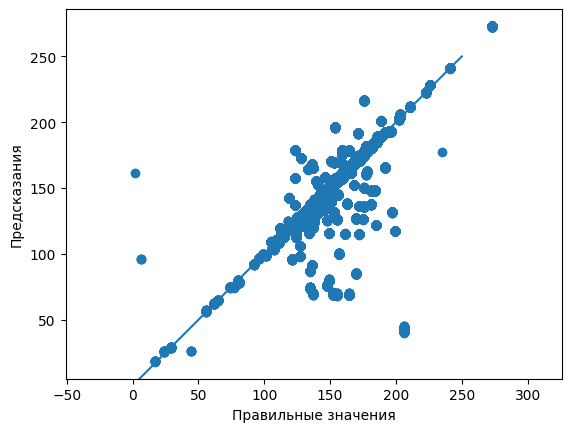

In [11]:
def check_MAE(model, x_data, x_data_text, y_data, plot=False):
    y_pred = model.predict([x_data, x_data_text]).squeeze()
    mae = np.mean(np.abs(y_data - y_pred))
    print(f'Средняя абсолютная ошибка: {mae:.3f} очков')

    if plot:
        plt.scatter(y_data, y_pred)
        plt.xlabel('Правильные значения')
        plt.ylabel('Предсказания')
        plt.axis('equal')
        plt.xlim(plt.xlim())
        plt.ylim(plt.ylim())
        plt.plot([0, 250], [0, 250])
        plt.show()

check_MAE(model, xTrain, xBOW_text, yTrain, plot=True)